# Text processing

In het vorige vak hebben we manueel gewerkt met tekstuele data en een aantal stappen manueel gedaan.
Deze stappen waren onder andere:
* Tokenizing
* Leestekens verwijderen
* Omzetten naar lowercase
* Stemming
* Stopwoorden verwijderen
* ...

In deze stappen bekwamen we een bag of words. Dat is een vector-voorstelling van de tekst die bijhield hoe vaak elk woord van de woordenboek voorkwam in de tekst.
Het concept van vaak kan een geheel getal zijn maar ook een frequentie op basis van hoe vaak het woord in het algemeen voorkomt in de hele dataset (tf-idf).
Met deze vector hebben we dan ML-modellen getrained.

Om te werken met text vectorization zijn er twee belangrijke lagen binnen tensorflow:
* TextVectorization
* Embedding layer

# Text vectorization

De [Text Vectorization Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) is de basis laag die een hele reeks van de stappen die we vorig jaar manueel gedaan hebben, gaat doen voor ons.
Deze laag zet een batch van strings (1 example = 1 string) om naar een lijst van token indices.
De bedoeling van deze layer is om met meerdere woorden tegelijkertijd te werken, niet met tekstuele klasses (hiervoor gebruik je beter de StringLookupLayer)

Deze laag voert de volgende stappen uit:
* Standaardizeren van elk voorbeeldstring (leestekens verwijderen, lowercase, ...). Dit kan je ook zelf instellen door een functie mee te geven/
* tokenizing
* Eventueel opstellen van n-grams
* Elk token naar een index omzetten
* indexes van elk voorbeeld omzetten naar een vector van ints (sparse) of floats (dense)

Het is duidelijk dat de woordenboek die gebruikt wordt voor dit soort problemen heel belangrijk is.
Deze woordenboek/vocabulary kan ofwel meegegeven worden bij de constructie van de laag of geleerd worden uit de dataset met de **.adapt()** functie

In [7]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

text_dataset = tf.data.Dataset.from_tensor_slices(["Hello world", "this is a test"])    # trainingsdata

max_features = 10
max_len = 4

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=max_len
)

# deze adapt moet gebeuren voor de fit van het model -> hier gaat hij het woordenboek opbouwen
vectorize_layer.adapt(text_dataset)
vectorize_layer.get_vocabulary()

['', '[UNK]', 'world', 'this', 'test', 'is', 'hello', 'a']

In [8]:
# int output mode
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

input_data = ["Is this a task", "No"]   # testdata
model.predict(input_data)

1/1 [==============================] - 0s 71ms/step


array([[5, 3, 7, 1],
       [1, 0, 0, 0]], dtype=int64)

Let er hierbij op dat de output_sequence_length een belangrijke parameter is.
Deze parameter bepaald de maximale lengte van een zin die verwerkt wordt.
Van zinnen die langer zijn dan dit aantal woorden wordt het einde niet meer in rekening genomen.

In [9]:
input_data = ["Is this a task or a test", "No"]   # testdata
model.predict(input_data)

1/1 [==============================] - 0s 37ms/step


array([[5, 3, 7, 1],
       [1, 0, 0, 0]], dtype=int64)

In [12]:
# multihot
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode="multi_hot"
)

vectorize_layer.adapt(text_dataset)
print(vectorize_layer.get_vocabulary())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

input_data = ["Is this a task or a test", "a test"]   # testdata
model.predict(input_data)

['[UNK]', 'world', 'this', 'test', 'is', 'hello', 'a']
1/1 [==============================] - 0s 155ms/step


array([[1., 0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1.]], dtype=float32)

In [13]:
#count
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode="count"         # tellen in multi-hot hoeveel keer elk woord voorkomt
)

vectorize_layer.adapt(text_dataset)
print(vectorize_layer.get_vocabulary())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

input_data = ["Is this a task or a test", "a test test test"]   # testdata
model.predict(input_data)

['[UNK]', 'world', 'this', 'test', 'is', 'hello', 'a']
1/1 [==============================] - 0s 84ms/step


array([[2., 0., 1., 1., 1., 0., 2.],
       [0., 0., 0., 3., 0., 0., 1.]], dtype=float32)

In [15]:
# tfidf
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode="tf_idf"         # tellen in multi-hot hoeveel keer elk woord voorkomt, gecorrigeerd met in hoeveel inputs het voorkomt
)

vectorize_layer.adapt(text_dataset)
print(vectorize_layer.get_vocabulary())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

input_data = ["Is this a task or a test", "a test test test"]   # testdata
model.predict(input_data)

['[UNK]', 'world', 'this', 'test', 'is', 'hello', 'a']
1/1 [==============================] - 0s 91ms/step


array([[1.3862944, 0.       , 0.6931472, 0.6931472, 0.6931472, 0.       ,
        1.3862944],
       [0.       , 0.       , 0.       , 2.0794415, 0.       , 0.       ,
        0.6931472]], dtype=float32)

De tweede optie was om te werken met een reeds bestaande woordenboek.
Een voorbeeld hiervan zie je in de cell hieronder.
Merk op dat je hierbij de adapt functie niet nodig hebt omdat je reeds een woordenboek hebt en er dus niet door de dataset moet gegaan worden.

In [16]:
vocabulary = ["hello", "world", "test", "task"]

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    vocabulary=vocabulary
)

# geen adapt nodig hier want er is al een woordenboek

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

input_data = ["Is this a task or a test", "a test test test"]   # testdata
model.predict(input_data)

1/1 [==============================] - 0s 73ms/step


array([[1, 1, 1, 5, 1, 1, 4],
       [1, 4, 4, 4, 0, 0, 0]], dtype=int64)

# Embedding layer

Het nadeel van een bag-of-words representatie is dat (vooral als je werkt met one-hot, count, tf_idf voorstellingen) je heel snel een heel groot aantal features hebt.
Voor deze voorstellingen heb je namelijk een vector van een lengte gelijk aan het aantal woorden in je taal.
Als we dan proberen te werken met de Engelse taal zijn er momenteel een 170.000 actieve woorden en in het Nederlands kan dit zelfs oplopen tot 350.000 woorden.
Als we vectors van deze lengte doorheen een neuraal netwerk proberen te sturen dan gaat het aantal gewichten gemakkelijk te groot zijn om een efficient, goed werkend model te trainen.

De embedding layer biedt een oplossing voor dit probleem door deze heel grote vectors om te zetten naar een een kleinere vector.
Dit wordt op een bepaalde manier gedaan om zoveel mogelijk informatie te behouden en om ervoor te zorgen dat woorden/zinnen met een gelijkaardige betekenis leiden tot een vector die gelijkaardig is.
Dit laatste wordt gedaan door de laag te trainen.
Dit kan je zien met behulp van onderstaand voorbeeld.

In [26]:
import numpy as np

# Define 10 restaurant reviews
reviews =[
          'Never coming back!',
          'horrible service',
          'rude waitress',
          'cold food',
          'horrible food!',
          'awesome',
          'awesome services!',
          'rocks',
          'poor work',
          'couldn\'t have done better'
]
#Define labels
labels = np.array([1,1,1,1,1,0,0,0,1,0])

max_features = 4000
max_len = 5

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens = max_features,
    output_mode="int",
    output_sequence_length=max_len
)

vectorize_layer.adapt(reviews)  # stel woordenboek op
voc = vectorize_layer.get_vocabulary()
print(voc)


model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

embedding = tf.keras.layers.Embedding(
    input_dim=len(voc),
    output_dim=8,
    input_length=max_len
)
model.add(embedding)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

result = model.predict(reviews)
print(result)
print(result.shape)


['', '[UNK]', 'horrible', 'food', 'awesome', 'work', 'waitress', 'services', 'service', 'rude', 'rocks', 'poor', 'never', 'have', 'done', 'couldnt', 'coming', 'cold', 'better', 'back']
1/1 [==============================] - 0s 77ms/step
[[0.50894576]
 [0.49906418]
 [0.5075968 ]
 [0.5002316 ]
 [0.50248927]
 [0.5203443 ]
 [0.5237206 ]
 [0.5166307 ]
 [0.5076946 ]
 [0.5000466 ]]
(10, 1)


In [27]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics="acc")
model.fit(np.array(reviews), labels, epochs=100)     # np.array toegevoegd omdat hij een error geeft van een list met strings in en een ndarray verwacht

Epoch 1/100
1/1 [==============================] - 0s 351ms/step - loss: 0.7004 - acc: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6977 - acc: 0.7000
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6951 - acc: 0.7000
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6925 - acc: 0.7000
Epoch 5/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6899 - acc: 0.7000
Epoch 6/100
1/1 [==============================] - 0s 9ms/step - loss: 0.6873 - acc: 0.7000
Epoch 7/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6847 - acc: 0.7000
Epoch 8/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6822 - acc: 0.7000
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6796 - acc: 0.7000
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6771 - acc: 0.7000
Epoch 11/100
1/1 [==============================] - 0s 7ms/step - loss: 0.67

In [28]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(embedding)

result = model.predict(reviews)

print(result[0])
print(result[1])
print(result[5])
print(result[6])

1/1 [==============================] - 0s 70ms/step
[[-0.06751344  0.10913604  0.08963987 -0.13533    -0.12803595 -0.13993467
  -0.06320789 -0.13917497]
 [ 0.09950032 -0.07429127  0.13021801  0.07609008  0.13192415  0.0892982
  -0.07705485  0.08932331]
 [ 0.15387483 -0.0521545  -0.1263566  -0.06699432  0.09208169  0.08625455
   0.03645432 -0.13149278]
 [-0.09597197  0.03050097 -0.08561945 -0.12672745 -0.07926934  0.07998829
   0.00899859 -0.10850864]
 [-0.09597197  0.03050097 -0.08561945 -0.12672745 -0.07926934  0.07998829
   0.00899859 -0.10850864]]
[[-0.05855052  0.13747776  0.07279737 -0.09865155 -0.07599299 -0.05144841
  -0.08933021 -0.13819373]
 [ 0.14325856 -0.04252816  0.05491921  0.05198886  0.0656728   0.09407751
  -0.07748551  0.13699444]
 [-0.09597197  0.03050097 -0.08561945 -0.12672745 -0.07926934  0.07998829
   0.00899859 -0.10850864]
 [-0.09597197  0.03050097 -0.08561945 -0.12672745 -0.07926934  0.07998829
   0.00899859 -0.10850864]
 [-0.09597197  0.03050097 -0.08561945 -

Het trainen van deze embedding layers is mogelijk maar dit kan heel snel heel complex worden omdat je hiervoor juist wel moet werken met deze grootte tensors.
Dit kan snel je pc overbelasten of te veel van je RAM geheugen innemen.
Gelukkig is het mogelijk om ook te werken met pre-trained embedded layers.
Hoe je dit doet, kan je [hier](https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings) lezen maar een snapshot zie je in onderstaande code:

In [ ]:
import opendatasets as od
import zipfile

od.download("http://nlp.stanford.edu/data/glove.6B.zip") # let op, dit is bijna 1 gb

In [ ]:
with zipfile.ZipFile("glove.6B.zip") as zf:
    zf.extractall("./pretrained")

In [29]:
path_to_glove_file = "./pretrained/glove.6B.50d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [30]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18 words (2 misses)


In [33]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,          # dimensies van de gekozen pretrained embedding
    embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(embedding_layer)

result = model.predict(reviews)
print(result)
print(result.shape)

1/1 [==============================] - 0s 80ms/step
[[[ 0.095387  -0.16865   -0.11514   ... -0.42103   -0.53817    0.13738  ]
  [ 0.2169     0.010103   0.20451   ...  0.047386  -0.018309  -0.014132 ]
  [ 0.0046218 -0.25678    0.3532    ... -0.80837   -0.33017   -0.62638  ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 [[ 0.3614    -0.55138   -0.70054   ...  0.23911    0.60709    0.44516  ]
  [ 0.13409    0.68926    0.45086   ...  0.29695   -0.006097   0.94897  ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 [[-0.4129    -0.37602   -0.99697   ...  0.57652    0.78847    1.4029   ]
  [-0.071998   0.14877   -0.97656   ... -0.80378    0.63032    0.97174  ]
  [ 0.         0.         0.        ...  0.         0.  

# Recurrente Neurale Netwerken

Zoals in de les besproken zijn recurrente neurale netwerken een type van neurale netwerken waarbij er een bepaalde state bijgehouden wordt
die doorgegeven wordt doorheen de tijd.
Dit wil dus zeggen dat we de woorden/n-grammen 1 voor 1 aan het neuraal netwerk doorgeven (ook als sequentie genoemd).
De output is dan ook een sequentie dus is het belangrijk om deze output bij te houden doorheen de tijd.

De bedoeling van deze structuren is om geheugen in het netwerk te introduceren.
Hierdoor is het mogelijk om complexere verbanden te detecteren doorheen de tijd in bijvoorbeeld geschreven tekst, audio of video.
Om dit geheugen toe te voegen in neurale netwerken kunnen de volgende lagen gebruikt worden:
* RNN
* LSTM
* GRU

RNN is de basis structuur. Het voordeel van deze structuur is dat het de eenvoudigste is maar het geheugen dat hierdoor voorzien word is maar kort.
Deze laag heeft snel problemen door het vanishing gradient problem.
De LSTM en GRU lagen zijn complexer en werken met gates om te bepalen welke informatie bijgehouden wordt in de state en welke genegeerd wordt.
Hierdoor kunnen deze lagen een langer geheugen hebben.
De benodigde rekenkracht voor deze lagen licht wel een stuk hoger.
Ook is er een hogere kans dat deze lagen overfitten en door de complexere structuur is het toevoegen van dropout ook complexer.

Er zijn 4 types netwerk architecturen die mogelijk zijn bij het werken met recurrente neurale netwerken, namelijk:
* One-to-One
* Many-to-One
* One-to-Many
* Many-to-Many

In de rest van deze notebook worden deze 4 architecturen bestudeerd. Op het einde bekijken we ook de resultaten van een populair pre-trained netwerk, namelijk het BERT netwerk, om te werken met tekstuele data.

## One-to-One

Eerst gaan we kijken naar de one-to-one architectuur. 
Dit is eigenlijk overeenkomstig met alles wat we reeds gedaan hebben want dit is dat je 1 input geeft en je krijgt 1 output. Er is geen state die doorgegeven wordt naar de volgende tijdstappen.

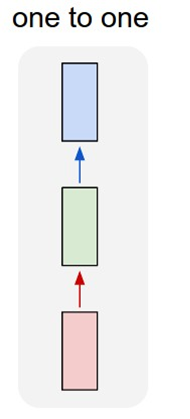

## Many-to-One

Een tweede architectuur waar wel sprake is van recurrente verbindingen is de many-to-one architectuur.
Dit is de typische architectuur voor classificatie van teksten.
Hierbij geef je woord per woord door wat je input is en op het einde heb je 1 output, namelijk de klasse van de tekst.

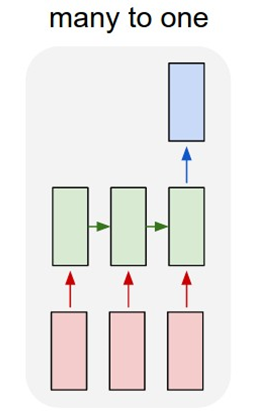

In de code hieronder staat er een voorbeeld om dit soort problemen op te lossen voor fake news classificatie.

In [35]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading misinformation-fake-news-text-dataset-79k.zip to .\misinformation-fake-news-text-dataset-79k


100%|██████████| 84.6M/84.6M [00:03<00:00, 28.3MB/s]


In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

df_fake = pd.read_csv("./misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_FAKE.csv")
df_fake["label"] = 1
df_true = pd.read_csv("./misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_TRUE.csv")
df_true["label"] = 0
df = pd.concat([df_fake, df_true])[["text", "label"]]
df = df.dropna()

# note - alle fake news staat eerst, daarna het echte nieuws --> hiermee moet rekening gehouden worden bij het splitsen
display(df.head())

max_text_length = 4#df.text.str.len().max()
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train = tf.convert_to_tensor(X_train.to_list())
X_test =  tf.convert_to_tensor(X_test.to_list())
y_train =  tf.convert_to_tensor(y_train.to_list())
y_test =  tf.convert_to_tensor(y_test.to_list())

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [51]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78588 entries, 0 to 34974
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78588 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [52]:
max_features = 10000

# tokenization
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens = max_features,
    output_mode="int",
    output_sequence_length=int(max_text_length)
)

vectorize_layer.adapt(X_train)  # stel woordenboek op

voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# embedding layer

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,          # dimensies van de gekozen pretrained embedding
    embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc2 in position 0: unexpected end of data

In [46]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(embedding_layer)
model.add(tf.keras.layers.SimpleRNN(units=100))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_18 (Text  (None, 142961)           0         
 Vectorization)                                                  
                                                                 
 embedding_7 (Embedding)     multiple                  1100      
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               15100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 16,301
Trainable params: 15,201
Non-trainable params: 1,100
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=3, batch_size=32)
model.evaluate(X_test, y_test, verbose=0)

In [ ]:
# met LSTM en dropout

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    tf.keras.layers.LSTM(units=100, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])        
model.fit(X_train, y_train, epochs=3, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

# waarschijnlijk niet beter dan RNN omdat het te korte sequenties zijn

In [ ]:
# met GRU en dropout

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    tf.keras.layers.GRU(units=100, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])        
model.fit(X_train, y_train, epochs=3, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

## Many-to-many



Dit soort architecturen heeft een sequentie van woorden als input en ook een sequentie als output.
Een typisch voorbeeld hiervan is het maken van een model dat tekst genereert op basis van een begintekst.

De code voor het voorbeeld bestaat uit de volgende stappen:
* Maken van sequenties van woorden en volgende woorden
* De woorden in deze sequenties omzetten naar embeddings
* Opbouwen van een model
* Trainen van het model
* Experimenteren met het model.

**1. Maken van de sequenties**

In de eerste stap gaan we tekst inladen en de zinnen omzetten naar sequenties en de woorden die erachter komen.
De data die we hiervoor gaan gebruiken zijn de artikels uit de vorige dataset met artikels.
Dit kan je doen door middel van de volgende code:


In [67]:
# in dit deel gaan we proberen het volgende woord in een zin te voorspellen
# daarvoor gaan we sequenties maken van 30 woorden en in de Y-waarde het volgende woord (embedded - int)

import numpy as np
import tensorflow as tf

sequenties = []
next_words = []
sequence_length=30
sequence_step=1
max_features = 4000

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int')
vectorize_layer.adapt(X_train)

def extract_input_data(row):
  article = row.text
  tokens = vectorize_layer(article)
  for i in range(0, len(tokens)-sequence_length, sequence_step):
    sequenties.append(tokens[i: i+sequence_length])
    next_words.append(tokens[i+sequence_length])

df.sample(n=200).apply(extract_input_data, axis=1)

print("number of sequences", len(sequenties))
print("number of words", len(next_words))

number of sequences 85357
number of words 85357


In [68]:
sequenties[0]

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([   6,    1,  135,  529,  243,  470,    1,    2,  534,  207, 2523,
         85,  605,  161,  173,    1,   51,    1,   70,   69,  437,   27,
          6,  135,   14,   65,    1,   43, 1207,   10], dtype=int64)>

**2. Woorden omzetten naar embeddings**

In [69]:
# embedding
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,        # belangrijk -> niet opnieuw aanpassen want reeds getrained
)

Converted 3901 words (99 misses)


In [70]:
X = np.zeros((len(sequenties), sequence_length, embedding_dim), dtype=float)
y = np.zeros((len(sequenties), 1), dtype=int)

for i in range(0, len(sequenties)):
  if i%1000 == 0:
    print(i)
  for j in range(sequence_length):
    X[i,j] = embedding_layer(sequenties[i][j])
  y[i] = next_words[i]

C:\Users\jens.baetens3\AppData\Local\Temp\ipykernel_12268\527969825.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.zeros((len(sequenties), sequence_length, embedding_dim), dtype=np.float)
C:\Users\jens.baetens3\AppData\Local\Temp\ipykernel_12268\527969825.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000


**3. Opstellen van een model**

Hierbij maken we gebruik van een nieuwe laag.
Namelijk de [**Bidirectional**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/) laag.
Deze laag maakt het mogelijk om de sequentie zowel voorwaarts als achterwaarts te bestuderen.
Dit zorgt ervoor dat bepaalde tijdsreeksen zoals tekst veel beter geanalyseerd en gemodelleerd kunnnen worden door een RNN.
Dit gebeurd in onderstaande code

In [ ]:

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation="relu"), input_shape=(sequence_length, embedding_dim)))    # bidirectioneel -> niet enkel verleden naar toekomst maar ook omgekeerde volgorde, de layer ertussen moet wel 1 zijn met geheugen/sequentie
model.add(tf.keras.layers.Dense(1))

model.compile(loss="mse", optimizer="adam")

model.summary()

In [ ]:
model(tf.expand_dims(X[0],0))

**4. Trainen van een model**

In [ ]:
model.fit(X,y, batch_size=64, shuffle=True, epochs=2, validation_split=0.1)

model.save("text_generator.h5")

**5. Genereren van tekst**

Wanneer we nu een beginsequentie aan het model geven, dan kan het volgende woord voorspeld worden.
Dit woord kan dan toegevoegd worden aan de sequentie en het volgende woord kan voorspeld worden.
Door dit te herhalen kan je een tekst van willekeurige lengte voorspellen.

Een probleem hierbij is nog dat we embeddings voorspellen.
Dit is een vector voorstelling van elk woord.
Deze vectors moeten nog terug geconverteerd worden naar een woord.

Deze conversies worden uitgevoerd door onderstaande code:

In [ ]:
test = "eric"
test_index = vectorize_layer(test)
test_embedding = embedding_layer(test_index)

print("Origineel woord", test)
print("index van origineel", test_index)
print("Embedding van origineel", test_embedding)
print("Shape embedding", test_embedding.shape)

# de embedding layer berekent eigenlijk de vector zoals een neuraal netwerk.
# we kunnen hiervan de omgeerde berekenen als volgt: (source: https://stackoverflow.com/questions/45773660/reverse-word-embeddings-in-keras-python)
voc_values = tf.linalg.matmul(test_embedding,tf.linalg.pinv(embedding_layer.weights[0]))
index = np.argmax(voc_values)
test_reverted_word = vectorize_layer.get_vocabulary()[index]

print("index reversed word", index)
print("reversed word", test_reverted_word)

In [ ]:
# dit is een functie die eigenlijk gebruikt kan worden om van een embedding terug te keren naar de integer van het woord en daarna naar het bijhorende woord.
def reverse_embedding(word_embeddings):
  voc_values = tf.linalg.matmul(word_embeddings,tf.linalg.pinv(embedding_layer.weights[0]))
  # index is het index in de woordenboek
  index = np.argmax(voc_values)
  test_reverted_word = vectorize_layer.get_vocabulary()[index]

  return test_reverted_word

Met bovenstaande functie kunnen we dan embeddings gaan voorspellen en terug omzetten naar tekst.
Dit gebeurd in onderstaande code.

In [ ]:
num_words_to_generate = 30
generated = ''
sentence = []

seed_sentence = "The winner of the elections is going to be "
generated = seed_sentence
# omdat text vectorization niet aanwezig is in het model
seed = embedding_layer(vectorize_layer(seed_sentence))
seed_X = np.zeros((1, sequence_length, embedding_dim))
seed_X[0, -len(seed):] = seed

# make prediction for each word
for i in range(num_words_to_generate):
  preds = model.predict(seed_X, verbose=0)
  # print(preds)

  # save predicted word
  next_word = int(preds)
  generated += ' ' + next_word
  sentence.append(next_word)

  # shift sequence
  tmp = seed_X.copy()
  seed_X[0,:-1] = seed_X[0, 1:]  
  seed_X[0, -1] = embedding_layer(next_word)  
  difference = ((tmp-seed_X) **2).sum()
  print(difference)

print("Result is:")
print(seed_sentence, ' '.join(sentence))

## One-to-many

In dit soort van problemen beginnen we van 1 enkele input waarden die we een aantal keer hergebruiken om zo meerdere outputs te genereren.
Dit kan je zien in onderstaande figuur.

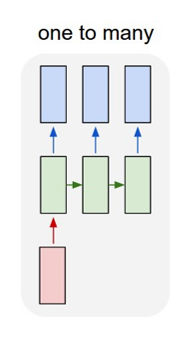

Als voorbeeld hiervan gaan we kijken of de volgende 5 getallen van een getal kunnen voorspeld worden aan de hand van recurrent neuraal netwerk.

De eerste stap in dit voorbeeldje moeten we dan deze experimentele dataset aanmaken.
Dit kan als volgt:

In [53]:
import tensorflow as tf
import numpy as np

max_int = 100
num_samples = 100
output_length = 5

X = np.random.randint(max_int, size=(num_samples))
X = X.astype('float')
Y = np.zeros((num_samples, output_length))

print(Y.shape)

for i in range(num_samples):
  Y_element = np.zeros(output_length)
  for j in range(output_length):
    Y_element[j] = X[i]+j+1
  Y[i] = Y_element

print(X)
print(Y)

(100, 5)
[21. 67. 79. 56. 16. 23.  3. 94. 43.  5. 40.  8. 49. 46. 67. 12. 79. 91.
 34. 78. 73. 20. 59. 83. 91. 37. 74. 59. 84. 86. 99. 23. 63. 57. 77. 69.
 81. 67. 23. 48. 33. 96. 59. 18. 39. 49. 88. 26. 89. 92. 67. 64. 72. 66.
 12. 25. 18. 36. 13. 82. 63. 68. 70. 49. 33.  8.  7. 21. 84. 47. 87.  0.
 42. 25. 63. 79. 69. 80. 63. 11. 62. 55. 92. 62. 76. 42. 71. 53. 50. 59.
 49.  4.  2. 89. 83. 44. 66. 45. 85. 74.]
[[ 22.  23.  24.  25.  26.]
 [ 68.  69.  70.  71.  72.]
 [ 80.  81.  82.  83.  84.]
 [ 57.  58.  59.  60.  61.]
 [ 17.  18.  19.  20.  21.]
 [ 24.  25.  26.  27.  28.]
 [  4.   5.   6.   7.   8.]
 [ 95.  96.  97.  98.  99.]
 [ 44.  45.  46.  47.  48.]
 [  6.   7.   8.   9.  10.]
 [ 41.  42.  43.  44.  45.]
 [  9.  10.  11.  12.  13.]
 [ 50.  51.  52.  53.  54.]
 [ 47.  48.  49.  50.  51.]
 [ 68.  69.  70.  71.  72.]
 [ 13.  14.  15.  16.  17.]
 [ 80.  81.  82.  83.  84.]
 [ 92.  93.  94.  95.  96.]
 [ 35.  36.  37.  38.  39.]
 [ 79.  80.  81.  82.  83.]
 [ 74.  75.  76.  77.  7

Om deze dataset te gebruiken voor een recurrent neuraal netwerk met een one-to-many architectuur moet er laag gebruikt worden die de enkelvoudige input elke tijdsstap van de sequentie aanrijkt aan het neuraal netwerk.
Hiervoor kan je de [RepeatVector layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector) gebruiken van tensorflow.

Om de output te berekenen kan je werken op de volledige sequence en voor elke waarde in de sequence iets voorspellen. Het nadeel is hiervoor dat je meer gewichten en neuronen nodig hebt.
Het is ook mogelijk om dezelfde laag uit te voeren op elk entry van de sequence.
Hiervoor heb je de [TimeDistributed layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) nodig om dit uit te voeren.

Een one-to-many model kan bijvoorbeeld als volgt opgebouwd worden.

In [66]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.RepeatVector(output_length))       # repeat vector: gebruik deze input voor elke stap in de sequentie

model.add(tf.keras.layers.LSTM(100, activation="relu", return_sequences=True))   # return sequence omdat we een many hebben als output (elke waarde van de sequentie is belangrijk)
model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True))  # zo lang de vorige laag sequences returned kan je meerdere recurrente lagen hebben

model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))    # time distributed (doe het deel in het argument voor elke stap in de sequentie)

model.compile(optimizer="adam", loss="mse")

model.fit(tf.expand_dims(X,1), Y, epochs=100, validation_split=0.2, verbose=1, batch_size=10)

Epoch 1/100
8/8 [==============================] - 1s 56ms/step - loss: 3568.7974 - val_loss: 3224.7827
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 2254.3162 - val_loss: 1978.5000
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 1615.9186 - val_loss: 1579.0347
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 1311.1547 - val_loss: 1237.1747
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 930.7518 - val_loss: 794.8100
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 587.0837 - val_loss: 511.2780
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 385.5200 - val_loss: 330.9010
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 248.4911 - val_loss: 185.9567
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 113.9540 - val_loss: 44.1825
Epoch 10/100
8/8 [==============================] - 0s 27ms/step - loss: 18

Voorspellingen kunnen gemaakt worden via onderstaande code

In [56]:
X.shape

(100,)

In [58]:
tf.expand_dims(X,1).shape

TensorShape([100, 1])

In [64]:
model(np.array([20]))

<tf.Tensor: shape=(1, 5, 1), dtype=float32, numpy=
array([[[21.037455],
        [21.978521],
        [22.973032],
        [24.035181],
        [25.006842]]], dtype=float32)>

In [61]:
np.arange(20,25)

array([20, 21, 22, 23, 24])